Ở phần trước, chúng ta đã thấy được cách vận transfer learning để trích xuất đặc trưng từ mô hình đã được học để giải quyết vấn đề của chúng ta. Và nó đã đem lại kết quả tốt hơn rất nhiều so với mô hình tự chúng ta xây dựng. 

Bây giờ chúng ta sẽ đề cập đến một kiểu transfer learning khác: đó là tinh chỉnh (fine-tuning) 

Nội dung trong phần này : 
1. Giới thiệu về  transfer learning tinh chỉnh.
2. Tải tập dữ liệu và tiền xử lý dữ liệu 
3. Sử dụng Keras API để thử nghiệm nhanh mô hình tinh chỉnh (một cách khác để xây dựng mô hình trong Keras)
 + 3.1 Model 0 : Xây dựng mô hình transfer learning bằng Keras API với EfficientNetB0
 + 3.2 Vectơ đặc trưng từ một mô hình train
4. Tạo Data augmentation và thử nghiệm với mô hình 
5. Thử nghiệm mô hình hóa trên dữ liệu food  
   + 5.1. Model 1 : Xây dựng mô hình transfer learning trích xuất đặc trưng trên 1% dữ liệu được tăng tính đa dạng  (data augmentation)
   + 5.2. Model 2 : Xây dựng mô hình transfer learning trích xuất đặc trưng trên 10% dữ liệu được tăng tính đa dạng  (data augmentation)
      + Giới thiệu hàm callback ModelCheckpoint để lưu kết quả train
   + 5.3. Model 0 : Xây dựng mô hình transfer learning được tinh chỉnh trên 10% dữ liệu train ban đầu
   + 5.4. Model 2 : Xây dựng mô hình transfer learning được tinh chỉnh trên 10% dữ liệu trainđược tăng tính đa dạng.
   + 5.5. Model 2 : Xây dựng mô hình transfer learning được tinh chỉnh trên toàn bộ dữ liệu train được tăng tính đa dạng.
6. So sánh kết quả thử nghiệm mô các mô hình hình bằng TensorBoard





Trước khi đi qua từng nội dung, trong suốt các thử nghiệm học máy từ các module trước, bạn có để ý rằng có rất nhiều hàm được sử dụng lặp đi lặp lại từ module này đến module khác không? Chẳng hạn như hàm để giải nén file thì dùng `unzip_file()`, khai thác các folder và file bên trong 1 folder nào đó với `walk_through_directory()`, hoặc vẽ đường learning rate của mô hình `plot_loss_curves()`... 

Để notebook được gọn gàng, chúng ta sẽ tạo một file `utility_functions.py` để lưu giữ các hàm có thể tái sử dụng nhiều lần này

In [1]:
!wget https://www.dropbox.com/s/pdotqeh8255s4bp/utility_functions.py

--2021-09-10 02:04:52--  https://www.dropbox.com/s/pdotqeh8255s4bp/utility_functions.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pdotqeh8255s4bp/utility_functions.py [following]
--2021-09-10 02:04:52--  https://www.dropbox.com/s/raw/pdotqeh8255s4bp/utility_functions.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc96db40782643af466003117347.dl.dropboxusercontent.com/cd/0/inline/BV0B9faR1haeOOB2ICEaRl9xWRrH-_x0dTFJFR0yAyWkccIpku-hcvYO34w1W5I53v9GJGkmDsLzOyhl41Y4f45nREIW1v61wV1Q0sNRjNqBUnPfjwaTYWgyj9SSPk7PL6zgF1Q3ROPNwxJ2bmHoA69y/file# [following]
--2021-09-10 02:04:52--  https://uc96db40782643af466003117347.dl.dropboxusercontent.com/cd/0/inline/BV0B9faR1haeOOB2ICEaRl9xWRrH-_x0dTFJFR0yAyWkccIpku-hcvYO34w1W5I53v

In [2]:
from utility_functions import unzip_file, plot_loss_curves, create_tensorboard_callback, walk_through_directory


## 1. Giới thiệu về transfer learning tinh chỉnh

Transfer learning tinh chỉnh cho phép các trọng số (weights) của mô hình đã được train trước đó được phép thay đổi (không còn bị đóng băng) và được điều chình trong quá trình này để phù hợp hơn với dữ liệu của riêng bạn.

Đối với mô hình transfer learning trích xuất đặc trưng, bạn chỉ có thể thay đổi một vài layer trên cùng (layer gần với dữ liệu đầu ra) của mô hình được train trước để train dữ liệu của bạn, nhưng trong transfer learning tinh chỉnh, bạn có thể train nhiều layer hơn (hoặc có thể là tất cả). 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Tính năng transfer learning trích xuất so với transfer learning tinh chỉnh. Sự khác biệt chính giữa cả hai là transfer learning tinh chỉnh có thể thay đổi nhiều layer của mô hình đã được train trước đó hơn trên  dữ liệu tùy chọn. Việc tinh chỉnh này thường tốn nhiều dữ liệu hơn là trích xuất tính năng để đạt hiệu quả.*


## 2. Tải tập dữ liệu và tiền xử lý dữ liệu

Trước khi train mô hình với tập dữ liệu lớn, chúng ta sẽ bắt đầu với tập dữ liệu nhỏ hơn, cụ thể ta sẽ tải xuống 10% dữ liệu train và toàn bộ dữ liệu test cho 10 class food.

In [3]:
!wget https://www.dropbox.com/s/mkm0q76ng7uy430/10_food_classes_10_percent.zip

--2021-09-10 02:04:55--  https://www.dropbox.com/s/mkm0q76ng7uy430/10_food_classes_10_percent.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mkm0q76ng7uy430/10_food_classes_10_percent.zip [following]
--2021-09-10 02:04:55--  https://www.dropbox.com/s/raw/mkm0q76ng7uy430/10_food_classes_10_percent.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc33b6d0460101521d46620716d5.dl.dropboxusercontent.com/cd/0/inline/BV1xUh10xsdds2yQ8HXJckAtx6_HjZebgw1jJ-evopAEzB708rc9uZBLYKVkyZJmkfLa1sDc2zDHgBLjef2gyrK7AHhVtEDBw1xWKBP3FblTqBWX68gRRVCy5daBm8h3q-iNlQ0IKRQuZBfE_Fc0Wzio/file# [following]
--2021-09-10 02:04:55--  https://uc33b6d0460101521d46620716d5.dl.dropboxusercontent.com/cd/0/inline/BV1xUh10xsdds2yQ8HXJckAtx6_HjZebgw1j

In [4]:
unzip_file("/content/10_food_classes_10_percent.zip")

Unzipped file


In [5]:
walk_through_directory("/content/10_food_classes_10_percent")

Có 2 thư mục và 0 tập tin trong thư mục /content/10_food_classes_10_percent
Có 10 thư mục và 0 tập tin trong thư mục /content/10_food_classes_10_percent/test
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/greek_salad
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/pad_thai
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/panna_cotta
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/prime_rib
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/bruschetta
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/spaghetti_bolognese
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/filet_mignon
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_percent/test/pulled_pork_sandwich
Có 0 thư mục và 250 tập tin trong thư mục /content/10_food_classes_10_

Chúng ta có thể thấy rằng mỗi thư mục train chứa 75 hình ảnh và mỗi thư mục test chứa 250 hình ảnh.

Tiếp theo, ta sẽ định nghĩa đường dẫn thư mục `train` và `test` 

In [6]:
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

Bây giờ chúng ta đã có một số dữ liệu hình ảnh, chúng ta cần một cách để đưa chúng sang định dạng tương thích với TensorFlow.

Ở phần trước, chúng ta đã sử dụng `ImageDataGenerator` để làm điều này. Tuy nhiên, trong phần này sẽ giới thiệu đến bạn một hàm khác cũng tương tự như  `ImageDataGenerator` trên. Đó là `image_data_from_directory`

Một ưu điểm khi sử dụng `tf.keras.preprocessing.image_dataset_from_directory` so với `ImageDataGenerator` là nó tạo ra một đối tượng `tf.data.Dataset` (API này xử lý nhanh hơn và hiệu quả hơn nhiều so với `ImageDataGenerator` khi xử lý với dữ liệu lớn)

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [8]:
IMAGE_SHAPE = (224,224)

train_data_10_percent = image_dataset_from_directory(train_dir, 
                                          label_mode="categorical",
                                          image_size=IMAGE_SHAPE,
                                          batch_size=32)

test_data = image_dataset_from_directory(test_dir, 
                                         label_mode="categorical",
                                         image_size=IMAGE_SHAPE,
                                         batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


các tham số chính mà chúng ta quan tâm trong funtion `image_dataset_from_directory()` : 

+ `directory` : đường dẫn đến thư mục đích nơi mà chúng ta sẽ tải hình ảnh từ đó đến mô hình
+ `label_mode` : kiểu dữ liệu được đưa vào mô hình
+ `image_size` : kích thước chung của hình ảnh mà chúng ta sẽ tải vào (height, width).
+ `batch_size` : số hình ảnh được chia theo từng cụm mà chúng ta sẽ tải vào. VD `batch_size` là 32 có nghĩa là một cụm xử lý sẽ chứa 32 hình ảnh kèm theo 32 label tương ứng với hình ảnh đó. 

Ngoài ra còn một số tham số khác có thể tham khảo tại [`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).




In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

+ `(None, 224, 224, 3)` đề cập đến hình dạng tensor của hình ảnh. Trong đó `None` là số cụm (batch_size) được xác định khi bắt đầu gọi hàm `fit` của mô hình, `224` tại vị trí `1` và `2` lần lượt là là `height` và `width` và `3` là các kênh màu (đỏ, lục, lam).
+ `(None, 10)` đề cập đến hình dạng tensor của label. `None` là số cụm (batch_size) được xác định khi bắt đầu gọi hàm `fit` của mô hình, `10` là số lượng labels đại diện cho 10 class khác nhau.

Bạn có thể coi `None` như một trình giữ chỗ đang chờ được lấp đầy với tham số batch_size từ `image_dataset_from_directory()`.

Một ưu điểm khác của việc sử dụng API `tf.data.Dataset` là có các phương thức liên kết đi kèm với nó.

Ví dụ, nếu chúng ta muốn tìm tên của các class mà chúng ta đang làm việc, chúng ta có thể sử dụng thuộc tính `class_names`.

In [10]:
class_names = train_data_10_percent.class_names
class_names 

['bruschetta',
 'clam_chowder',
 'filet_mignon',
 'garlic_bread',
 'greek_salad',
 'pad_thai',
 'panna_cotta',
 'prime_rib',
 'pulled_pork_sandwich',
 'spaghetti_bolognese']

Hoặc nếu chúng ta muốn xem một cụm dữ liệu mẫu, chúng ta có thể sử dụng phương thức `take()`.

In [11]:
for images, labels in train_data_10_percent.take(1) : 
  print(images, labels)

tf.Tensor(
[[[[2.90867348e+01 2.90867348e+01 1.90867348e+01]
   [2.83724480e+01 2.83724480e+01 1.63724480e+01]
   [2.82346954e+01 3.06632671e+01 1.64489822e+01]
   ...
   [6.77043152e+01 7.57043152e+01 8.71328430e+01]
   [6.46684341e+01 7.26684341e+01 8.36684341e+01]
   [7.49484482e+01 8.29484482e+01 9.39484482e+01]]

  [[1.86734695e+01 1.86734695e+01 8.67346764e+00]
   [2.47959194e+01 2.67959194e+01 1.39285717e+01]
   [3.37346954e+01 3.61632690e+01 2.27346954e+01]
   ...
   [8.00102539e+01 8.80102539e+01 9.90102539e+01]
   [7.36530533e+01 8.26530533e+01 9.16530533e+01]
   [7.66786270e+01 8.56786270e+01 9.46786270e+01]]

  [[3.33673477e+01 3.35816345e+01 2.55816326e+01]
   [2.42551003e+01 2.60408154e+01 1.56836729e+01]
   [2.37091827e+01 2.58316326e+01 1.37346945e+01]
   ...
   [8.08368301e+01 8.98368301e+01 9.88368301e+01]
   [7.36734848e+01 8.26734848e+01 9.16734848e+01]
   [8.03317032e+01 8.93317032e+01 9.83317032e+01]]

  ...

  [[1.49714401e+02 1.67500137e+02 1.53071609e+02]
   [1

Đặc biệt, khi sử dụng API `tf.data.Dataset`, các label sẽ tự động được `one_hot`. VD: `clam_chowder` có giá trị label là 2 trong tổng số 10 label thì khi mã hóa dưới dạng one_hot sẽ là `[0,0,1,0,0,0,0,0,0,0]`

## 3. Sử dụng Keras API để thử nghiệm nhanh mô hình tinh chỉnh (một cách khác để xây dựng mô hình trong Keras)

### 3.1 Model 0 : Xây dựng mô hình transfer learning bằng Keras API với EfficientNetB0

chúng tôi sẽ sử dụng module `tf.keras.application` vì nó chứa một loạt các mô hình thị giác máy tính đã được đào train trên ImageNet cũng như hàm API Keras để xây dựng mô hình.

Chúng ta sẽ thực hiện các bước sau:

1. Khởi tạo mô hình đã được train trước đó là mô hình cơ sở bằng việc lựa chọn mô hình `EfficientNetB0` từ `tf.keras.application`, thiết lập `include_top` là `False` vì kết quả đầu ra với dữ liệu của chúng ta muốn dự đoán cho `10` class thay vì là `1000` như của mô hình đó.
2. Đặt thuộc tính `trainable` của mô hình cơ sở này là `False` để giữ nguyên các trọng số của mô hình. 
3. Định nghĩa Input layer cho mô hình (định nghĩa kích thước mỗi hình được đưa mô hình)
4. [Tùy chọn] Chuẩn hóa giá trị inputs cho mô hình. Mô số mô hình thị giác máy tính có yêu cầu phải chuẩn hóa input như `ResNetV250`, còn với `EfficientNetB0` thì nó không cần vì nó đã có sẵn trong mô hình cơ sở. 
5. Đưa Input layer đó vào mô hình cơ sở
6. Nhóm các output (đầu ra) của mô hình cơ sở thành một hình dạng tương thích với activation function của output layer ( chuyển các tensor đầu ra của  mô hình cơ sở có cùng hình dạng với tensor của label). Điều này có thể thực hiện bằng [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) hoặc [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en).
7. Tạo một activation function cho output layer bằng cách sử dụng `tf.keras.layers.Dense()` sao cho phù hợp với kiểu mô hình.
8. Tạo mô hình bằng `tf.keras.Model` và đưa 2 giá trị inputs, outputs được xây dựng ở bước `3` và `7` vào đó. 
9. Compile (biên dịch) mô hình bằng cách sử dụng hàm loss thích hợp và chọn trình tối ưu hóa .
10. Điều chỉnh mô hình cho số lượng epochs mong muốn và sử dụng các callback function (trong trường hợp của chúng này, chúng ta sẽ bắt đầu với hàm call bacjk TensorBoard để ghi lại quá trình hoạt động của mô hình).

Trước khi xây dựng mô hình, chúng ta sẽ import thư viện Tensorflow và kiểm tra xem google colab hiện tại có sử dụng GPU không

In [12]:
import tensorflow as tf

In [13]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-b521b993-1f39-5024-932c-aa30515328a9)


In [14]:
IMAGE_SHAPE=(224,224,3)
# 1. Khởi tạo mô hình đã được train trước đó là mô hình cơ sở bằng việc lựa chọn mô hình EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Đặt thuộc tính trainable của mô hình cơ sở này là False để giữ nguyên các trọng số của mô hình.
base_model.trainable = False 

# 3. Định nghĩa Input layer cho mô hình (định nghĩa kích thước mỗi hình được đưa mô hình)
inputs = tf.keras.Input(shape=IMAGE_SHAPE,name="input_layer")

# 4.[Tùy chọn] Chuẩn hóa giá trị inputs cho mô hình
# x = tf.keras.layers.Rescaling(scale=1/255.)(inputs) # Với EfficientNetB0 hiện tại chúng ta không cần bước này

# 5. Đưa Input layer đó vào mô hình cơ sở
x = base_model(inputs)

print(x.shape)
# 6.Nhóm các output (đầu ra) của mô hình cơ sở thành một hình dạng tương thích với 
# activation function của output layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool_2d")(x)
print(f"After globalAvgPooling2D : {x.shape}")

# 7. Tạo một activation function cho output layer bằng cách sử dụng tf.keras.layers.Dense()
# sao cho phù hợp với kiểu mô hình
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output")(x)

# 8. Tạo mô hình bằng tf.keras.Model và đưa 2 giá trị inputs, outputs được xây dựng ở bước 3 và 7 vào đó.
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile (biên dịch) mô hình bằng cách sử dụng hàm loss thích hợp và chọn trình tối ưu hóa .
model_0.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# 10. Điều chỉnh mô hình cho số lượng epochs mong muốn và sử dụng các callback function 
model_0_history = model_0.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=5, 
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[
                create_tensorboard_callback("transfer_learning_fine_tuning", "efficientB0_10_percent_data")
    ]
)


(None, 7, 7, 1280)
After globalAvgPooling2D : (None, 1280)
Đã lưu tensorboard vào transfer_learning_fine_tuning/efficientB0_10_percent_data/10092021-020505
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 732ms/step - loss: 1.8282 - accuracy: 0.4173 - val_loss: 1.2683 - val_accuracy: 0.7388
Epoch 2/5
24/24 [==============================] - 14s 591ms/step - loss: 1.0626 - accuracy: 0.7640 - val_loss: 0.8454 - val_accuracy: 0.8260
Epoch 3/5
24/24 [==============================] - 14s 584ms/step - loss: 0.7660 - accuracy: 0.8387 - val_loss: 0.6777 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 14s 590ms/step - loss: 0.6156 - accuracy: 0.8547 - val_loss: 0.5891 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 14s 593ms/step - loss: 0.5181 - accuracy: 0.8907 - val_loss: 0.5391 - val_accuracy: 0.8604


Sau hơn một phút đào , mô hình của chúng tôi hoạt động cực kỳ tốt trên cả quá trình đào tạo (độ chính xác ~90% ) và bộ kiểm tra (độ chính xác ~85%).  Tất cả là nhờ vào sức mạnh của transfer learning. Điều quan trọng cần lưu ý là transfer learning mà chúng ta sử dụng ở đây được gọi là transfer learning trích xuất đặc tính, tương tự như những gì chúng ta đã làm với các mô hình TensorFlow Hub ở phần trước. 

Nói cách khác, chúng ta đã chuyển dữ liệu tùy chỉnh của mình sang một mô hình đã được train trước (EfficientNetB0). 

Chúng ta cũng đã sử dụng hàm API Keras để xây dựng mô hình của mình thay vì API Sequential. 

> 📖 Bonus: Để thấy được những ưu điểm của kỹ thuật sử dụng Functional Keras API so với Sequential API, bạn có thể tham khảo tại [TensorFlow Functional API documentation](https://www.tensorflow.org/guide/keras/functional).

Kiểm tra layers của `model_0`

In [15]:
for layer_index, layer in enumerate(model_0.layers) : 
  print(layer_index, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 False
2 global_avg_pool_2d True
3 output True


Kiến trúc tổng quan của `model_0`

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2d (GlobalAv (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


`model_0` có 4 layer nhưng thực sự trong layer `efficientnetb0` có 236 đến 236 layer.

Bạn có thể thấy hình dạng của input layer trong mô hình là `[(None, 224, 224, 3)]`, nhưng đến output layer, hình dạng của nó lại là `(None, 10)`, với `None` là trình giữ chỗ cho kích thước lô.

Cũng lưu ý rằng, các tham số duy nhất có thể train trong mô hình là các tham số trong output layer.

Kiểm tra layers trong `base_model`

In [17]:
for layer_index, layer in enumerate(model_0.layers[1].layers) : 
  print(layer_index, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

Có rất nhiều layer ... để viết tay tất cả những các layer này sẽ mất một thời gian khá dài để thực hiện, nhưng chúng ta vẫn có thể cải thiện chúng nhờ vào sức mạnh của transfer learning.

Check xem mô kiến trúc tổng quan của `base_model` 


In [18]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

Kiểm tra learning curves của  mô hình

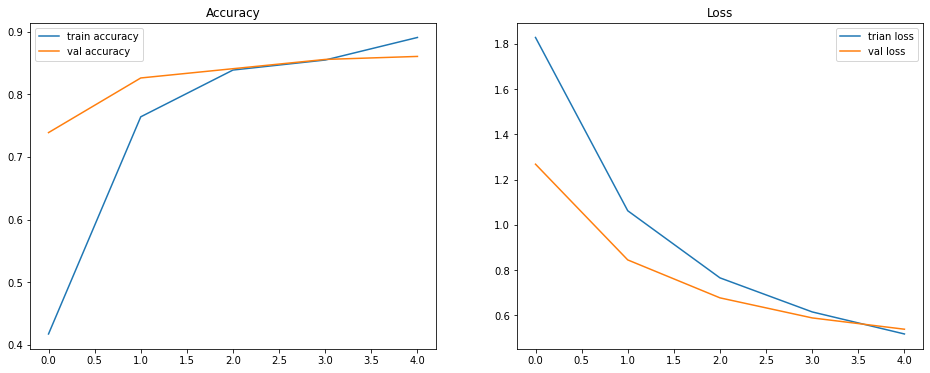

In [19]:
plot_loss_curves(model_0_history)

### 3.2 Lấy một vectơ đặc trưng từ một mô hình train

> 🤔 Câu hỏi: Điều gì xảy ra với `tf.keras.layers.GlobalAveragePooling2D()`? Tôi chưa thấy nó bao giờ.

`tf.keras.layers.GlobalAveragePooling2D()` biến tensor 4D thành tensor 2D bằng cách lấy trung bình các giá trị trên các trục bên trong.

In [20]:
# VD 
input_shape = (1,3,3,3)
random_tensor = tf.random.normal(input_shape)
print(f"Random tensor:\n {random_tensor}\n")
print(f"Shape of random tensor : {random_tensor.shape}")

global_avg_pool_2d = tf.keras.layers.GlobalAveragePooling2D()(random_tensor)
print(f"Global average pooling 2d: {global_avg_pool_2d}")
print(f"Shape of global_avg_pool_2d : {global_avg_pool_2d.shape}")

Random tensor:
 [[[[-0.85918516 -1.6557547  -0.37063125]
   [ 1.0982836   2.6986556   0.33071968]
   [-0.4787695  -1.2003943  -0.08261332]]

  [[-1.3780017  -0.41197175  0.1733369 ]
   [-1.0328573   0.33863676  0.4147187 ]
   [-0.67725706 -1.090697    0.6458288 ]]

  [[ 0.63724226  0.45865574 -0.01746214]
   [ 0.6404494  -1.2814807  -1.0716159 ]
   [ 1.2379069  -1.0169531   1.274494  ]]]]

Shape of random tensor : (1, 3, 3, 3)
Global average pooling 2d: [[-0.09024313 -0.35125595  0.14408617]]
Shape of global_avg_pool_2d : (1, 3)


Khi gọi hàm `tf.keras.layers.GlobalAveragePooling2D()` cho một tensor nào đó, nó sẽ lấy giá trị trung bình của tensor đó qua 2 trục giữa khiến cho hình dạng ban đầu từ `(1, 3, 3, 3)` bị rút gọn lại còn `(1,3)`.

Có thể làm thủ công như sau: 


In [21]:
tf.reduce_mean(random_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09024313, -0.35125595,  0.14408617]], dtype=float32)>

Việc gộp trung bình này không chỉ giúp cho hình dạng của output trở nên tương thích với yêu cầu hình dạng của input mà nó còn cô đọng thông tin được tìm thấy bởi mô hình cơ sở thành một vectơ đặc trưng có kích thước thấp hơn.

> 🔑 **Lưu ý**: Một trong những lý do khiến transfer learning trích xuất đặc tính được đặt tên như vậy là do những gì xảy ra bên trong một mô hình được trước sẽ xuất ra một vectơ đặc trưng ( là một dãy số dài được gộp lại lấy giá trị trung bình)

Vậy còn `tf.keras.GlobalMaxPool2D()` thì sao ? Với random_tensor  như trên ta sẽ thử xem nó sẽ là gì

In [22]:
print(f"Random tensor:\n {random_tensor}\n")
print(f"Shape of random tensor : {random_tensor.shape}")

global_max_pool_2d = tf.keras.layers.GlobalMaxPooling2D()(random_tensor)
print(f"Global average pooling 2d: {global_max_pool_2d}")
print(f"Shape of global_max_pool_2d : {global_max_pool_2d.shape}")

Random tensor:
 [[[[-0.85918516 -1.6557547  -0.37063125]
   [ 1.0982836   2.6986556   0.33071968]
   [-0.4787695  -1.2003943  -0.08261332]]

  [[-1.3780017  -0.41197175  0.1733369 ]
   [-1.0328573   0.33863676  0.4147187 ]
   [-0.67725706 -1.090697    0.6458288 ]]

  [[ 0.63724226  0.45865574 -0.01746214]
   [ 0.6404494  -1.2814807  -1.0716159 ]
   [ 1.2379069  -1.0169531   1.274494  ]]]]

Shape of random tensor : (1, 3, 3, 3)
Global average pooling 2d: [[1.2379069 2.6986556 1.274494 ]]
Shape of global_max_pool_2d : (1, 3)


Chúng ta có thể mô phỏng quá trình này bằng cách sử dụng `tf.reduce_max()` và chỉ định các trục thích hợp.

In [23]:
tf.reduce_max(random_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.2379069, 2.6986556, 1.274494 ]], dtype=float32)>

## 4. Data augmentation 

**Data augmentation** là cách làm cho tập dữ liệu train của bạn đa dạng hơn mà không cần thêm nhiều dữ liệu hơn.

Trước đây, chúng ta đã từng tạo data augmentation với  `ImageDataGenerator`, nhưng lần này, chúng ta sẽ không làm như vậy mà sẽ xây dựng data augmentation ngay trên mô hình với `tensorflow.keras.layers.experimental.preprocessing`. 

Đây là một tính năng tương đối mới được thêm vào từ TensorFlow 2.2+ nhưng nó rất mạnh mẽ. Việc thêm một data augmentation layer vào mô hình có những ưu điểm sau : 
+ Việc xử lý trước những hình ảnh (tặng cường tính đa dạng cho chúng) diễn ra ngay trên GPU thay vì CPU, mà GPU thì xử lý với tới độ nhanh hơn rất nhiều. Đối với dữ liệu hình ảnh môi trường xử lý tốt nhất và nhanh nhất là GPU, trong khi với những dữ liệu bằng văn bản hoặc dữ liệu có cấu trúc thì phù hợp với CPU hơn. 
+ Sự tăng tính đa dạng cho dữ liệu hình ảnh chỉ xảy ra cho quá trình train vì vậy chúng ta vẫn có thể export toàn bộ mô hình và sử dụng nó ở những nơi khác. Và nếu ai đó muốn train mô hình tương tự như chúng ta, bao gồm các dữ liệu được tăng tính đa dạng, họ có thể train được. 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Ví dụ về việc sử dụng tăng tính đa dạng cho dữ liệu ở layer tiên trong mô hình (EfficientNetB0).*

Để sử dụng kỹ thuật tăng tính đa dạng (data augmentation) cho dữ liệu ngay trong mô hình, chúng ta sẽ tạo một mô hình Keras Sequential chỉ bao gồm các layer tiền xử lý dữ liệu, sau đó chúng ta có thể sử dụng mô hình Sequential này trong một mô hình dạng hàm khác.

Các phép biến đổi tăng tính đa dạng cho dữ liệu mà chúng tôi sẽ sử dụng là:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) -lật hình ảnh trên trục ngang hoặc trục dọc.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - xoay ngẫu nhiên hình ảnh theo trên một lương đã xác định.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - phóng to ngẫu nhiên một hình ảnh trên một lượng đã chỉ định.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - thay đổi ngẫu nhiên chiều cao hình ảnh theo một lượng xác định.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - thay đổi ngẫu nhiên chiều rộng hình ảnh theo một lượng xác định.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - chuẩn hóa các giá trị pixel của hình ảnh từ 0 đến 1, điều này đáng nói vì nó là bắt buộc đối với một số mô hình hình ảnh nhưng vì chúng ta đang triển khai mô hình `EfficientNetB0` nên không bắt buộc.

In [24]:
import tensorflow as tf 
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.layers.experimental import preprocessing

In [25]:
data_augmentation = Sequential([
  preprocessing.RandomFlip(mode="horizontal"),
  preprocessing.RandomRotation(0.25),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.3),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(scale=1/255.) # Với EfficientNetB0 chúng ta không cần rescale
],name="data_augmentation")

Mô hình tuần tự tăng độ đa dạng của dữ liệu đã sẵn sàng. Như bạn sẽ thấy ngay sau đó, chúng tôi sẽ có thể sắp xếp "mô hình" này như một layer vào mô hình transfer learning sau này.

Nhưng trước khi bắt đầu xây dựng mô hình, chúng ta sẽ hiển thị hình ảnh bất kỳ với data augmentation

Text(0.5, 0.98, 'pulled_pork_sandwich')

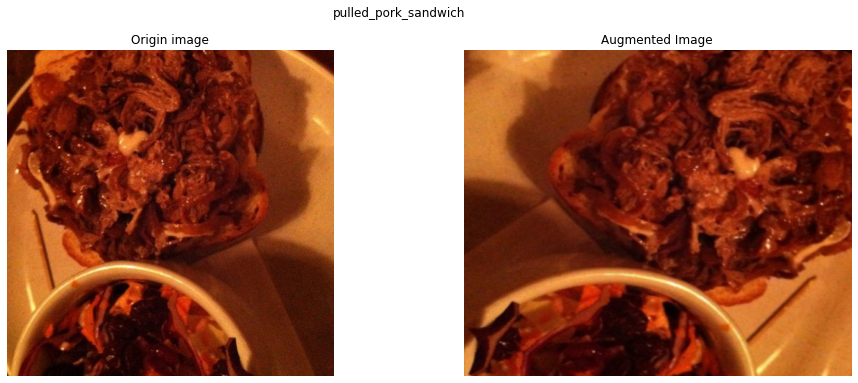

In [26]:
import random 
import os
import matplotlib.pyplot as plt 

target_class = random.choice(os.listdir(train_dir))
target_class_path = os.path.join(train_dir, target_class)
random_image_name = random.choice(os.listdir(target_class_path))
random_image_path = os.path.join(target_class_path, random_image_name)
image = plt.imread(random_image_path)
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(image)
plt.title("Origin image")
plt.axis(False)

plt.subplot(122)
augmented_image = data_augmentation(tf.expand_dims(image,axis=0))  # vì mô hình data augmentation bắt buộc có dạng (None, height, width, 3)
augmented_image = tf.squeeze(augmented_image, axis=0)/255. # để hiển thị hình ảnh, sau bạn cần chuẩn hóa chúng và bỏ đi chiều đầu tiên
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis(False)
plt.suptitle(target_class)


Chạy ô phía trên một vài lần và bạn có thể thấy các những hình ảnh ngẫu nhiên sẽ bị biến dạng khác nhau tùy thuộc các tỉ lệ ngẫu nhiên của các tham số đã được thiết lập.

Làm điều này sẽ làm cho tập dữ liệu train của chúng ta trở nên đa dạng hơn. Bạn có thể nghĩ như thể bạn đang chụp ảnh đồ ăn trong đời thực, không phải tất cả các hình ảnh đều hoàn hảo, một số hình ảnh sẽ được có hình dáng theo những cách kỳ lạ. Đây là những loại hình ảnh mà chúng ta muốn mô hình có thể xử lý.

Nói về mô hình, chúng ta sẽ áp dụng tất cả các bước giống như `model_0` ngoại trừ  sẽ thêm mô hình Tuần tự tăng tính đa dạng cho dữ liệu dưới dạng một layer ngay sau input layer


## 5. Thử nghiệm mô hình hóa trên dữ liệu food  


### 5.1 Model 1 : Xây dựng mô hình transfer learning trích xuất đặc trưng trên 1% dữ liệu đa tăng cường tính đa dạng (data augmentation)

Trước tiên chúng ta sẽ tải tập dữ liệu chứa 1% trong tổng dữ liệu đã được thực hiện trong `module 4: preprocessing data`

In [27]:
!wget https://www.dropbox.com/s/dryeebi147n37ra/10_food_classes_1_percent.zip

--2021-09-10 02:06:38--  https://www.dropbox.com/s/dryeebi147n37ra/10_food_classes_1_percent.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dryeebi147n37ra/10_food_classes_1_percent.zip [following]
--2021-09-10 02:06:39--  https://www.dropbox.com/s/raw/dryeebi147n37ra/10_food_classes_1_percent.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc46d646c68277f3b133becf6364.dl.dropboxusercontent.com/cd/0/inline/BV2XATnV6QNVQjJwvt4rqTuvF4vE5BVVAM0u6SEYZ8Su9j2S9VU59DVywmSZYtuNlV6eQ1iBbE6sIxo2odv0ITZ162vTt0Gs7RfkZ_1hDvOvEdJ6CpIgAS73ZWEJxRIA4gwCoeaW8g5sjeIXxY8Q1NpT/file# [following]
--2021-09-10 02:06:39--  https://uc46d646c68277f3b133becf6364.dl.dropboxusercontent.com/cd/0/inline/BV2XATnV6QNVQjJwvt4rqTuvF4vE5BVVAM0u6SE

In [28]:
unzip_file("/content/10_food_classes_1_percent.zip")

Unzipped file


In [29]:
walk_through_directory("10_food_classes_1_percent")

Có 2 thư mục và 0 tập tin trong thư mục 10_food_classes_1_percent
Có 10 thư mục và 0 tập tin trong thư mục 10_food_classes_1_percent/test
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/greek_salad
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/pad_thai
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/panna_cotta
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/prime_rib
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/bruschetta
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/spaghetti_bolognese
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/filet_mignon
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/pulled_pork_sandwich
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/garlic_bread
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes_1_percent/test/clam_chowde

+ Tập dữ liệu train hiên tại mỗi class chỉ có 1% dữ liệu tức là chỉ  có 7 hình để train cho 1 class. 
+ Tập dữ liệu test không có gì thay đổi so với 10% dữ liệu như trên. 

In [30]:
train_dir_1_percent_data_10_class = "10_food_classes_1_percent/train"
test_dir_1_percent_data_10_class = "10_food_classes_1_percent/test"

In [31]:
train_data_1_percent = image_dataset_from_directory(
    train_dir_1_percent_data_10_class, 
    image_size=(224,224),
    batch_size=32, 
    label_mode="categorical"
)

test_data = image_dataset_from_directory(
    test_dir_1_percent_data_10_class, 
    image_size=(224,224),
    batch_size=32, 
    label_mode="categorical"
)



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
train_data_1_percent.class_names

['bruschetta',
 'clam_chowder',
 'filet_mignon',
 'garlic_bread',
 'greek_salad',
 'pad_thai',
 'panna_cotta',
 'prime_rib',
 'pulled_pork_sandwich',
 'spaghetti_bolognese']

Kiểm tra xem class names của  mô hình 1% dữ liệu có khác với 10% dữ liệu hay không 

In [33]:
class_names_10_percent_data = train_data_10_percent.class_names
class_names_1_percent_data = train_data_1_percent.class_names 
assert set(class_names_10_percent_data) == set(class_names_1_percent_data)

Nếu class_names của 2 tập dữ liệu khác nhau, nó sẽ lập tức báo lỗi

In [34]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Tạo input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Tăng tính đa dạng cho inputs trên
augmented_inputs = data_augmentation(inputs)

# Chuẩn hóa dữ liệu inputs (đối với EfficientNetB0 thì bỏ qua bước này)
# normed_inputs = layers.Rescaling(scale=1/255.)

# Đưa augmented_inputs vào mô hình base_model
x = base_model(augmented_inputs)

# Nhóm các output đặc trưng của mô hình cơ sở 
global_avg_pool_2d = layers.GlobalAveragePooling2D(name="global_avg_pool_2d")(x)

# Đặt một dense layer như là outputs 
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(global_avg_pool_2d)

# Tạo mô hình với 2 tham số inputs và outputs 
model_1 = Model(inputs, outputs)

# Biên dịch mô hình với các hàm loss, kỹ thuật tối ưu hóa và phương pháp đo lường cho mô hình
model_1.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Fit mô hình
model_1_history = model_1.fit(
    train_data_1_percent,
    steps_per_epoch=len(train_data_1_percent),
    epochs=5, 
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[
      create_tensorboard_callback("transfer_learning_fine_tuning", "efficientB0_1_percent_data_augmentation")
    ]
)

Đã lưu tensorboard vào transfer_learning_fine_tuning/efficientB0_1_percent_data_augmentation/10092021-020646
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 17s 5s/step - loss: 2.4282 - accuracy: 0.0571 - val_loss: 2.2684 - val_accuracy: 0.1299
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1904 - accuracy: 0.2000 - val_loss: 2.1410 - val_accuracy: 0.1891
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9790 - accuracy: 0.2857 - val_loss: 2.0311 - val_accuracy: 0.3125
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.9081 - accuracy: 0.3714 - val_loss: 1.9317 - val_accuracy: 0.3470
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6743 - accuracy: 0.6143 - val_loss: 1.8225 - val_accuracy: 0.4391


Mô hình chỉ sử dụng 1% dữ liệu (7 hình ảnh đã được biến dạng ở mỗi class) để train, nhưng với số lượng hình ảnh ít ỏi đó, nó vẫn cho ra kết quả dự đoán rất tốt so với 50,67% của mô hình [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) nhưng được train với tất cả dữ liệu. 

Kiến trúc tổng quan của `model_1` 

In [35]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2d (GlobalAv (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Trong mô hình đã có `data_augmentation` là một layer được tích hợp ngay trong mô hình. Điều này cũng có nghĩa là khi chúng ta lưu lại mô hình này và load nó ở bất kỳ nơi nào khác thì data augmentation layers này vẫn gắn liền với mô hình. 

Một điều quan trọng nữa là `data augmentation chỉ chạy trong quá trình train` Vì vậy, nếu chúng ta đánh giá hoặc sử dụng mô hình của dự đoán một class nào đó của một hình ảnh, thì các data augmentation layer sẽ tự động ngắt. 


In [36]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 133ms/step - loss: 1.8288 - accuracy: 0.4368


[1.8288201093673706, 0.4368000030517578]

Kết quả ở đây có thể tốt hơn hoặc kém hơn một chút so với kết quả đầu ra của nhật ký của mô hình của chúng ta trong quá trình train, vì trong lúc train chúng ta chỉ đánh giá mô hình của mình trên 25% dữ liệu test bằng cách sử dụng dòng validation_steps = `int(0,25 * len (test_data))`. Việc rút ngắn số lượng dữ liệu test trong lúc train giúp tiết kiệm thời gian xử lý của mô hình. 

Tiếp theo, kiểm tra learning curves mà mô hình học qua mỗi epoch: 

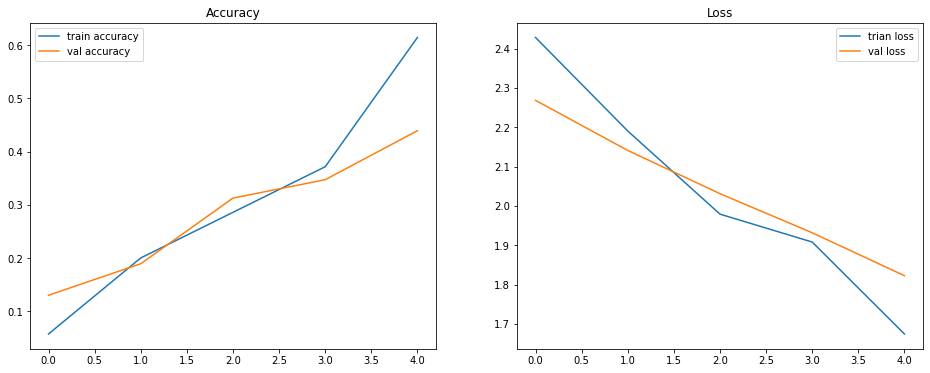

In [37]:
plot_loss_curves(model_1_history)

Có vẻ như các chỉ số đo lường hiệu suất trên cả hai tập dữ liệu có cùng quỹ đạo, hướng đi khá tương đồng nhau, và có khả năng mô hình sẽ cải thiện thêm nếu chúng ta tiếp tục train lâu hơn. Nhưng chúng ta sẽ chuyển sang train kiểu dữ liệu khác thay vì train lâu hơn như vậy. 

### 5.2. Model 2 : Xây dựng mô hình transfer learning trích xuất đặc trưng trên 10% dữ liệu đa tăng cường tính đa dạng (data augmentation)

Ở phần này chúng ta đã download tập dữ liệu trước đó để train `model_0`, nên không cần phải thực hiện các bước tải dữ liệu và khám phá khái quát thành phần của tập dữ liệu đó. Chúng ta sẽ xây dựng mô hình luôn. Phần này sẽ không giải thích lại vì nó tương tự như mô hình trên, bạn có thể tham khảo mô hình trên để nắm rõ hơn. 

In [38]:
IMAGE_SHAPE=(224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = layers.Input(shape=IMAGE_SHAPE, name="input_layer")

augmented_inputs = data_augmentation(inputs)

x = base_model(augmented_inputs)

global_avg_pooling_2d = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(len(class_names), activation="softmax", name="outputs")(global_avg_pooling_2d)

model_2 = Model(inputs, outputs)

model_2.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)


#### Giới thiệu hàm callback ModelCheckpoint để lưu kết quả train

Trong mô hình này, để tăng thêm sự mới mẻ chúng ta sẽ thêm một callback function có tên `ModelCheckpoint`. 

`ModelCheckpoint` callback cung cấp cho bạn khả năng lưu lại hoặc toàn bộ mô hình theo định dạng `SavedModel` hoặc chỉ lưu trọng số (mẫu) vào một thư mục được chỉ định khi nó đào tạo.

Điều này rất hữu ích nếu bạn nghĩ rằng mô hình của mình sẽ được train trong một thời gian dài nhưng không thể train được liên tục và bạn muốn sao lưu mô hình đã train lại. Điều đó cũng có nghĩa nếu bạn nghĩ rằng mô hình của mình có thể tốt hơn khi được train lâu hơn, thì bạn có thể tải lại mô hình đó từ vị trí đã lưu và tiếp tục train tiếp thay vì phải train lại từ đầu.

Ví dụ: giả sử bạn fit mô hình transfer learning trích xuất đặc trưng trong 5 epochs. Khi bạn kiểm tra các đường learning curves và thấy nó vẫn đang được cải thiện, lúc đó bạn muốn xem liệu việc tinh chỉnh thêm 5 epoch nữa liệu có thể  tốt hơn được không. Lúc này, bạn có load hàm callback checkpoint, giải nén một số (hoặc tất cả) các layer của mô hình cơ sở và sau đó tiếp tục train. Trên thực tế, đó chính xác là những gì chúng ta sẽ làm.

Nhưng trước tiên, chúng ta sẽ tạo hàm `ModelCheckpoint` để chỉ định một thư mục mà chúng ta muốn lưu vào.


In [39]:
def create_checkpoint_callback(checkpoint_dir, experiment_name) : 
  checkpoint_path = os.path.join(checkpoint_dir, experiment_name +".ckpt")  
  model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                     monitor="val_loss", 
                                     verbose=1,
                                     save_weights_only=True, # Chỉ lưu trọng số, nếu False sẽ save toàn bộ mô hình
                                     save_best_only=False, #True để save mô hình nào là tốt nhất, 
                                     save_freq="epoch" #lưu sau mỗi epoch
                                    )
  print(f"Đã lưu checkpoint callback tại :{checkpoint_path}")
  return model_checkpoint_cb

> 🤔 Câu hỏi: Lưu toàn bộ mô hình (định dạng SavedModel) và chỉ lưu trọng số  có gì khác nhau?

Định dạng `SavedModel` lưu toàn bộ kiến ​​trúc, trọng số và cấu hình train của mô hình vào trong một thư mục. Nó giúp bạn dễ dàng tải lại mô hình của mình một cách chính xác như thế nào ở nơi khác. Tuy nhiên, nếu bạn không muốn chia sẻ tất cả những thông tin chi tiết này với người khác, bạn có thể chỉ muốn lưu và chia sẻ trọng số (đây sẽ chỉ là những con số lớn không thể giải thích được bởi con người). Nếu dung lượng ổ đĩa là một vấn đề, chỉ lưu trọng số sẽ nhanh hơn và chiếm ít dung lượng hơn so với lưu toàn bộ mô hình.

Bởi vì chúng ta sẽ tinh chỉnh nó sau đó, nên chúng ta sẽ tạo một biến `initial_epochs` và đặt nó là 5 để sử dụng sau này.



In [40]:
initial_epochs = 5 
model_2_history = model_2.fit(
    train_data_10_percent, 
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[
             create_tensorboard_callback("transfer_learning_fine_tuning", "efficientB0_10_percent_data_augmentation"),
             create_checkpoint_callback(checkpoint_dir="checkpoints",experiment_name="model_2_10_percent_data_aug")
    ]
)

Đã lưu tensorboard vào transfer_learning_fine_tuning/efficientB0_10_percent_data_augmentation/10092021-020757
Đã lưu checkpoint callback tại :checkpoints/model_2_10_percent_data_aug.ckpt
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 29s 879ms/step - loss: 1.9575 - accuracy: 0.3573 - val_loss: 1.4083 - val_accuracy: 0.6546

Epoch 00001: saving model to checkpoints/model_2_10_percent_data_aug.ckpt
Epoch 2/5
24/24 [==============================] - 18s 730ms/step - loss: 1.2949 - accuracy: 0.6787 - val_loss: 0.9979 - val_accuracy: 0.7829

Epoch 00002: saving model to checkpoints/model_2_10_percent_data_aug.ckpt
Epoch 3/5
24/24 [==============================] - 16s 634ms/step - loss: 1.0098 - accuracy: 0.7373 - val_loss: 0.8052 - val_accuracy: 0.8125

Epoch 00003: saving model to checkpoints/model_2_10_percent_data_aug.ckpt
Epoch 4/5
24/24 [==============================] - 16s 651ms/step - loss: 0.8600 - accuracy: 0.7720 - val_loss: 0.7002 - val_accuracy: 0.8092

Epoch 00004: saving model to checkpoints/model_2_10_percent_data_aug.ckpt
Epoch 5/5
24/24 [==============================] - 14s 581ms/step - loss: 0.7580 - accuracy: 0.8040 - val_loss: 0.6536 - val_accuracy: 0.8158


Đánh giá mô hình với `test_data`

In [41]:
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 11s 131ms/step - loss: 0.6307 - accuracy: 0.8252


[0.6307364106178284, 0.8252000212669373]

Vẽ đường learning curves của mô hình 

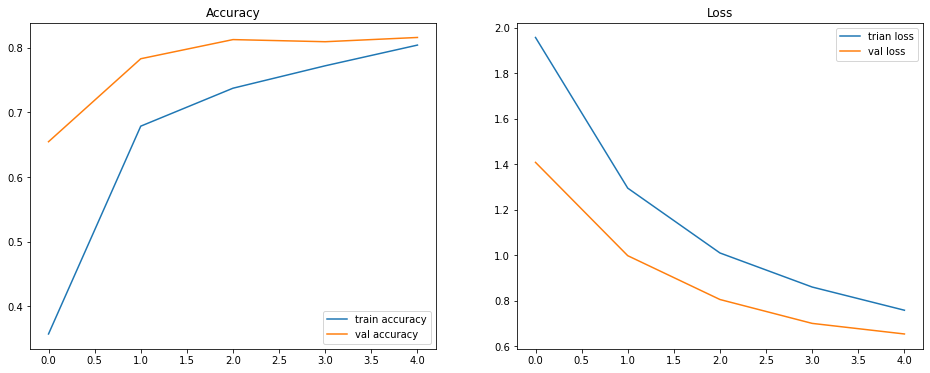

In [42]:
plot_loss_curves(model_2_history)

Với 10% dữ liệu ở mỗi class ( tức chỉ chỉ gấp 10 dữ liệu cho mỗi class) mô hình đã đạt được độ chính xác đáng kinh ngạc. Dù `model_0` và `model_2` có cùng dữ liệu và `model_0` có độ chính xác cao hơn so với `model_2` nhưng nếu để ngăn chặn overfitting cho mô hình, thì bạn cần chọn `model_2`. Ngoài ra, các đường cong đang có xu hướng đi đúng hướng, nghĩa là nếu chúng tôi train lâu hơn, các chỉ số của nó có thể sẽ được cải thiện theo hướng tốt như vậy.

Để load những trọng số mà mô hình đã lưu, bạn có thể sử dụng phương thức `load_weights()`, chuyển nó đến đường dẫn nơi lưu trữ trọng só đó.

In [43]:
model_2.load_weights("checkpoints/model_2_10_percent_data_aug.ckpt")

Lúc này mô hình đã load các trọng số được lưu tại `checkpoints/model_2_10_percent_data_aug.ckpt` 

In [44]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 134ms/step - loss: 0.6307 - accuracy: 0.8252


Bây giờ chúng ta sẽ so sánh kết quả của mô hình được train trước đó với mô hình được tải lên. Các kết quả này sẽ rất gần nếu không muốn nói là hoàn toàn giống nhau. Lý do cho những khác biệt nhỏ là do mức độ chính xác của các con số được tính toán.

In [45]:
result_10_percent_data_aug

[0.6307364106178284, 0.8252000212669373]

In [46]:
loaded_weights_model_results

[0.6307364106178284, 0.8252000212669373]

In [47]:
result_10_percent_data_aug == loaded_weights_model_results

True

### 5.3. Model 0 tinh chỉnh : Xây dựng mô hình transfer learning được tinh chỉnh trên 10% dữ liệu train ban đầu

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*Ví dụ cấp cao về việc tinh chỉnh mô hình EfficientNet. Các lớp dưới cùng (các lớp gần với dữ liệu đầu vào) vẫn được đóng băng khi các lớp trên cùng (các lớp gần với dữ liệu đầu ra) được cập nhật trong quá trình đào tạo.*

Ở những mô hình transfer learning trích xuất đặc trưng trước, chúng ta đã train 10% dữ liệu gốc và dữ liệu được tăng cường tính đa dạng với 5 epoch. Các layer trong `base_model` chúng ta chưa hề đả động đến, nó vẫn được sử dụng toàn bộ những trọng số, những kiến thức đã được train trước đó. Đối với mô hình tiếp theo, chúng ta sẽ chuyển sang transfer learning được tinh chỉnh. Điều này có nghĩa là chúng ta sẽ sử dụng cùng một mô hình `base_model`, nhưng sẽ mở cho một số layer của nó (những lớp gần với output) được có thể train với dữ liệu của chúng ta và chạy mô hình thêm một vài epoch nữa.


In [48]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2d (GlobalAv (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [49]:
for layer_index, layer in enumerate(model_0.layers) : 
  print(layer_index, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 False
2 global_avg_pool_2d True
3 output True


Tất cả các layer trong layer `Effectsnetb0` đã bị đóng băng. Chúng ta có thể xác nhận điều này bằng thuộc tính `trainable_variables`.

In [50]:
len(model_2.layers[1].trainable_variables)

0

Điều này giống với mô hình cơ sở `base_model`.

In [51]:
len(base_model.trainable_variables)

0

Thậm chí có thể kiểm tra từng layer trong `base_model`:

In [52]:
for layer_index, layer in enumerate(base_model.layers) : 
  print(layer_index, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Bây giờ để tinh chỉnh mô hình cơ sở phù hợp với dữ liệu của, chúng ta sẽ cho phép 10 layer trên cùng được phép train và tiếp tục train mô hình thêm 5 epoch tiếp theo.

Điều này có nghĩa là tất cả các layer của mô hình cơ sở ngoại trừ 10 layer cuối cùng sẽ vẫn bị đóng băng và không thể  train được. Và trọng số ở các layer được phép train sẽ được cập nhật trong quá trình train.

> 🤔 Câu hỏi: Bạn nên mở bao nhiêu lớp khi luyện tập?

Không có quy tắc thiết lập cho điều này. Bạn có thể unfreeze mọi layer trong mô hình được train trước ddos hoặc bạn có thể thử mở từng layer một. Tốt nhất hãy thử với số lượng lượng layer tăng dần dần được tinh chỉnh khác nhau để xem điều gì sẽ xảy ra. Nói chung, neus có càng có ít dữ liệu thì nên dùng ít layer có thể train. 

Để bắt đầu tinh chỉnh, trước tiên ta sẽ cho phép tính năng của `base_model.trainable` là `True`. Sau đó, tạo vòng lặp cho đến trước phần tử  thứ 10 tính từ cuối cùng đi lên và set cho những layer `trainable` là `False`. Cụ thể như sau : 

In [53]:
base_model.trainable = True

for layer in base_model.layers[:-10] : 
  layer.trainable = False

Kiểm tra có bao nhiêu layer có thê train trong trong `base_model` 


In [54]:
for layer_index, layer in enumerate(base_model.layers) : 
  print(layer_index, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Có vẻ như tất cả các layer ngoại trừ 10 layer cuối cùng đều bị đóng băng và không thể train được. Điều này có nghĩa là chỉ 10 layer cuối cùng của `base_model` cùng với output layer sẽ được cập nhật trọng số của chúng trong quá trình train. 

> 🤔 Câu hỏi: Tại sao chúng tôi biên dịch lại mô hình?

Mỗi khi thực hiện thay đổi đối trong mô hình của mình, bạn cần phải biên dịch lại chúng.

Trong trường hợp chúng ta đang sử dụng cùng một hàm loss, trình tối ưu hóa và không gian đo, ngoại trừ lần này `learning_rate` cho trình tối ưu hóa của chúng ta sẽ nhỏ hơn 10 lần so với trước đây (0,0001 thay vì mặc định của Adam là 0,001).

Chúng ta làm điều này để mô hình không cố gắng ghi đè các trọng số hiện có trong mô hình được đào tạo trước quá nhanh. Nói cách khác, chúng tôi muốn học dần dần.

> 🔑**Lưu ý** : Không có tiêu chuẩn thiết lập nào để đặt learning_rate trong quá trình tinh chỉnh, mặc dù mức giảm [2.6x-10x+ dường như hoạt động tốt  trong thực tế](https://arxiv.org/abs/1801.06146).


Bây giờ chúng ta có bao nhiêu biến có thể train? 

In [55]:
len(model_0.trainable_variables)

2

Chúng tôi sẽ tiếp tục train từ nơi mà mô hình trước đó đã hoàn thành. Vì nó được train trong 5 epochs, quá trình tinh chỉnh của chúng ta sẽ bắt đầu từ epoch thứ 5 và tiếp tục trong 5 với epoch tiếp theo.

In [56]:
fine_tune_epochs = 5 

model_0_fine_tune_history = model_0.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=initial_epochs+fine_tune_epochs, 
    initial_epoch=model_0_history.epoch[-1] + 1, 
    validation_data=test_data, 
    validation_steps=int(0.25 * len(test_data))
)

Epoch 6/10
24/24 [==============================] - 7s 268ms/step - loss: 0.4617 - accuracy: 0.8933 - val_loss: 0.5096 - val_accuracy: 0.8684
Epoch 7/10
24/24 [==============================] - 7s 268ms/step - loss: 0.4135 - accuracy: 0.9053 - val_loss: 0.4812 - val_accuracy: 0.8750
Epoch 8/10
24/24 [==============================] - 7s 267ms/step - loss: 0.3739 - accuracy: 0.9120 - val_loss: 0.4784 - val_accuracy: 0.8734
Epoch 9/10
24/24 [==============================] - 7s 268ms/step - loss: 0.3379 - accuracy: 0.9320 - val_loss: 0.4622 - val_accuracy: 0.8734
Epoch 10/10
24/24 [==============================] - 7s 268ms/step - loss: 0.3095 - accuracy: 0.9387 - val_loss: 0.4603 - val_accuracy: 0.8668


> 🔑 **Lưu ý**: Quá trình tinh chỉnh thường mất nhiều thời gian hơn trên mỗi epoch so với việc trích xuất đặc tính (do cập nhật nhiều trọng số hơn trong toàn neural).

In [57]:
# Đánh giá mô hình trên dữ liệu test 
result_fine_tune_10_percent = model_0.evaluate(test_data)
result_fine_tune_10_percent

79/79 [==============================] - 11s 133ms/step - loss: 0.4412 - accuracy: 0.8700


[0.44118955731391907, 0.8700000047683716]

Chúng ta sẽ so sánh khả năng học của mô hình giữa 2 giai đoạn trước khi tinh chỉnh  (5 epoch đầu) và sau khi tinh chỉnh (5 epoch sau) 

In [58]:
def compare_history(original_history, new_history) : 
  og_history = original_history.history 
  n_history = new_history.history 

  og_acc, og_val_acc = og_history["accuracy"], og_history["val_accuracy"]
  og_loss, og_val_loss = og_history["loss"], og_history["val_loss"]

  new_acc, new_val_acc = n_history["accuracy"], n_history["val_accuracy"]
  new_loss, new_val_loss = n_history["loss"], n_history["val_loss"]

  total_acc = og_acc + new_acc 
  total_val_acc = og_val_acc + new_val_acc
  total_loss = og_loss + new_loss
  total_val_loss = og_val_loss + new_val_loss   
  plt.figure(figsize=(20,6))
  plt.subplot(121)
  plt.plot(total_acc,label="train accuracy")
  plt.plot(total_val_acc, label="val accuracy")
  plt.plot([model_0_history.epoch[-1],model_0_history.epoch[-1]],plt.ylim(), label="Bắt đầu tinh chỉnh")
  plt.title("Compare accuracy history")  
  plt.xlabel("epochs")
  plt.ylabel("percentage")  
  plt.legend()
  plt.subplot(122)
  plt.plot(total_loss, label="train loss")
  plt.plot(total_val_loss, label="val loss")
  plt.plot([model_0_history.epoch[-1],model_0_history.epoch[-1]],plt.ylim(),label="Bắt đầu tinh chỉnh")
  plt.title("Compare loss history")
  plt.xlabel("epochs")
  plt.ylabel("value")  
  plt.legend()

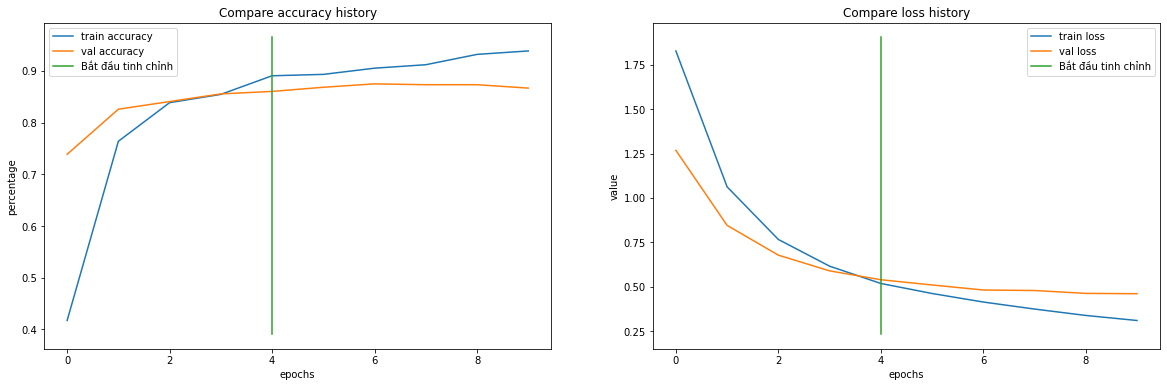

In [59]:
compare_history(model_0_history, model_0_fine_tune_history)

`model_0` có đã cải thiện đáng kể sau khi chúng ta cho phép một số layer trong `base_model` được phép train trên dữ liệu này. 

Tương tự, chúng ta sẽ áp dụng 10% dữ liệu train này vào `model_2` nhưng các dữ liệu này khi đưa vào mô hình sẽ có một layer sau đó sẽ thực hiện công việc "biến dạng" làm cho dữ liệu thay đổi đa dạng hơn.



### 5.4. Model 2 tinh chỉnh : Xây dựng mô hình transfer learning được tinh chỉnh trên 10% dữ liệu train tăng cường tính đa dạng.

In [60]:
from tensorflow.keras.utils import plot_model

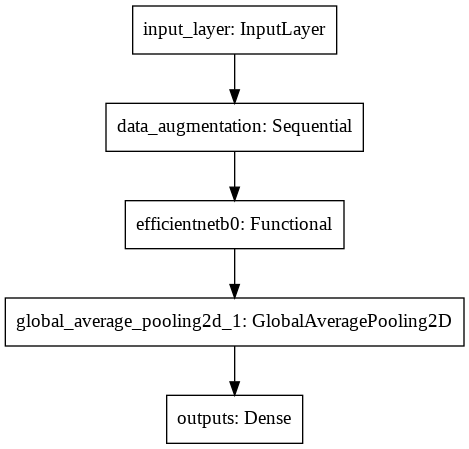

In [61]:
plot_model(model_2)

Chúng ta sẽ tận dụng lại `model_2` để thực hiện transfer learning tinh chỉnh

In [62]:
fine_tune_epoch=5

model_2.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_2_fine_tune_history = model_2.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=initial_epochs + fine_tune_epochs, 
    initial_epoch=model_2_history.epoch[-1] + 1,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)


Epoch 6/10
24/24 [==============================] - 24s 699ms/step - loss: 0.7477 - accuracy: 0.7693 - val_loss: 0.6167 - val_accuracy: 0.7928
Epoch 7/10
24/24 [==============================] - 16s 650ms/step - loss: 0.4199 - accuracy: 0.8613 - val_loss: 0.3909 - val_accuracy: 0.8668
Epoch 8/10
24/24 [==============================] - 15s 607ms/step - loss: 0.2981 - accuracy: 0.8893 - val_loss: 0.4184 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 15s 631ms/step - loss: 0.2041 - accuracy: 0.9453 - val_loss: 0.4593 - val_accuracy: 0.8454
Epoch 10/10
24/24 [==============================] - 14s 597ms/step - loss: 0.1624 - accuracy: 0.9560 - val_loss: 0.4702 - val_accuracy: 0.8487


Đánh giá `model_2` sau khi được tinh chỉnh 

In [63]:
results_fine_tune_10_percent_data_aug = model_2.evaluate(test_data)
results_fine_tune_10_percent_data_aug

79/79 [==============================] - 11s 132ms/step - loss: 0.4351 - accuracy: 0.8616


[0.4350980818271637, 0.8615999817848206]

Trong quá trình train, chúng ta chỉ sử dụng 25% dữ liệu test để đánh giá sau mỗi epoch. Khi đánh giá toàn bộ dữ liệu, có thể thấy tỉ lệ chính xác cao hơn.

So sánh khả năng học của mô hình giữa 2 giai đoạn trước khi tinh chỉnh và sau khi tinh chỉnh 

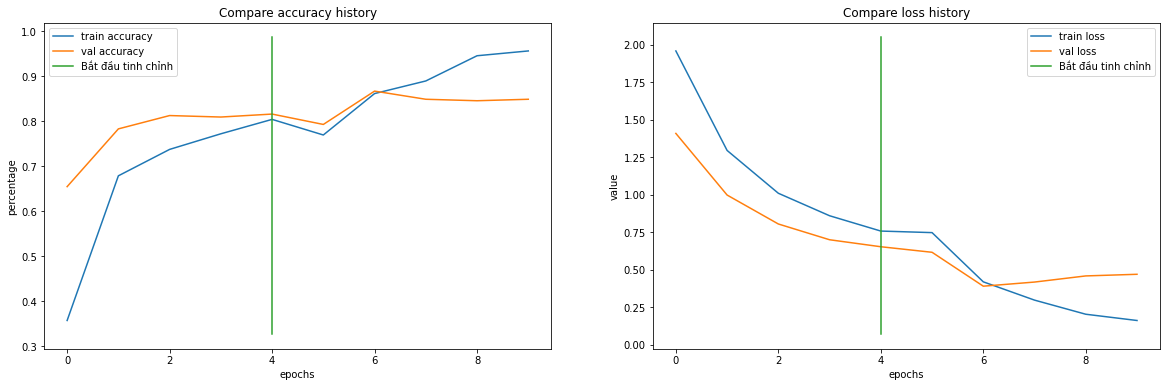

In [64]:
compare_history(model_2_history, model_2_fine_tune_history)

OK, với mô hình sau khi được tinh chỉnh, có vẻ nó cũng đã được cải thiện đáng kể. 

### 5.5. Model 2 : Xây dựng mô hình transfer learning được tinh chỉnh trên toàn bộ dữ liệu train được tăng tính đa dạng

Chúng ta đã xây dựng mô hình và thử nghiệm với những dữ liệu nhỏ. Có thể thấy khả năng học của mô hình là rất tốt. Bây giờ, chúng ta sẽ đưa toàn bộ dữ liệu vào để có thể có sự đánh giá tốt nhất đối với mô hình học. 

Trước hết chúng ta sẽ tải dữ liệu và khai thác các cấu trúc nằm trong tập dữ liệu đó có gì.

In [66]:
!wget https://www.dropbox.com/s/xjyf4ug18zqvig0/10_food_classes.zip

--2021-09-10 02:44:45--  https://www.dropbox.com/s/xjyf4ug18zqvig0/10_food_classes.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xjyf4ug18zqvig0/10_food_classes.zip [following]
--2021-09-10 02:44:45--  https://www.dropbox.com/s/raw/xjyf4ug18zqvig0/10_food_classes.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc397098e6940b845d34c92c1565.dl.dropboxusercontent.com/cd/0/inline/BV0HwhCVgHbWFA1zCGD4fOrCxC7v7BcVc52H84boWUXSh7q1qHhYH9XlE9o19HXwrFb3L8niEBzE02igwJZJy0bLQBKqHZYN0LLwL8fm8iDZGX3_aPj4KP8YtWvyaT7FqMmWp0JrUBGIswZuMsg9x8ki/file# [following]
--2021-09-10 02:44:45--  https://uc397098e6940b845d34c92c1565.dl.dropboxusercontent.com/cd/0/inline/BV0HwhCVgHbWFA1zCGD4fOrCxC7v7BcVc52H84boWUXSh7q1qHhYH9XlE9o19HXwrFb3L

In [67]:
unzip_file("10_food_classes.zip")

Unzipped file


In [68]:
walk_through_directory("10_food_classes")

Có 2 thư mục và 0 tập tin trong thư mục 10_food_classes
Có 10 thư mục và 0 tập tin trong thư mục 10_food_classes/test
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/greek_salad
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/pad_thai
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/panna_cotta
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/prime_rib
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/bruschetta
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/spaghetti_bolognese
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/filet_mignon
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/pulled_pork_sandwich
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/garlic_bread
Có 0 thư mục và 250 tập tin trong thư mục 10_food_classes/test/clam_chowder
Có 10 thư mục và 0 tập tin trong thư mục 10_food_classes/train
Có 0 thư mục và 750 tập tin trong thư mục 10_food_class

Trong tập dữ liệu `10_food_classes` có tổng cộng 10 class, mỗi class gồm 750 hình ảnh để `train`, 250 hình ảnh để `test`. 

Tạo đường dẫn đến tập dữ liệu 10 class đầy đủ

In [69]:
train_10_class_full_data_dir = "10_food_classes/train"
test_10_class_full_data_dir = "10_food_classes/test"

Chúng ta sẽ biến các hình ảnh thành bộ dữ liệu tensors.

In [70]:
IMAGE_SHAPE = (224,224)
train_full_data = image_dataset_from_directory(
    train_10_class_full_data_dir,
    label_mode="categorical",
    image_size=IMAGE_SHAPE
)

test_data = image_dataset_from_directory(
    test_10_class_full_data_dir,
    label_mode="categorical",
    image_size=IMAGE_SHAPE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Như hiện tại, `model_2` của chúng ta đã được tinh chỉnh trên 10% dữ liệu, vì vậy để bắt đầu tinh chỉnh tất cả dữ liệu và giữ cho các thử nghiệm được nhất quán, chúng ta cần load  nó về các trọng số mà chúng tôi đã kiểm tra sau 5 epoch mô hình trích xuất đặc tính. 

Tận dụng `CheckPoint callback` đã được thực hiện trong `model_2` để load lại trọng số và đặc tính trong 5 epoch đầu tiên.

In [71]:
model_2.load_weights("checkpoints/model_2_10_percent_data_aug.ckpt")

In [72]:
loaded_results_10_percent_data_aug = model_2.evaluate(test_data)
loaded_results_10_percent_data_aug

79/79 [==============================] - 11s 132ms/step - loss: 0.6307 - accuracy: 0.8252


[0.6307364106178284, 0.8252000212669373]

So sánh với kết quả đánh giá `model_2` của 5 epoch đầu tiên xem có khớp hay không

In [73]:
result_10_percent_data_aug

[0.6307364106178284, 0.8252000212669373]

In [74]:
loaded_results_10_percent_data_aug == result_10_percent_data_aug

True

Kiểm tra xem một số layer cuối cùng của mô hình cơ sở `base_model` đã cho phép train với dữ liệu mới hay chưa.

In [79]:
for layer_index, layer in enumerate(model_2.layers) : 
  print(layer_index, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d_1 True
4 outputs True


In [83]:
for layer_index, layer in enumerate(model_2.layers[2].layers) : 
  if layer.trainable: 
    print(layer_index, layer.name, layer.trainable)

227 block7a_se_squeeze True
228 block7a_se_reshape True
229 block7a_se_reduce True
230 block7a_se_expand True
231 block7a_se_excite True
232 block7a_project_conv True
233 block7a_project_bn True
234 top_conv True
235 top_bn True
236 top_activation True


Như vậy mô hình `model_2` đã được load lại lúc chưa tinh chỉnh. Bây giờ, chúng ta sẽ bắt đầu tinh chỉnh mô hình với full dữ liệu. Nhớ là bạn muốn thay đổi tham số nào đó trong mô hình, bạn phải compile nó lại.

In [78]:
model_2.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_2_fine_tune_all_data_history = model_2.fit(
    train_full_data,
    steps_per_epoch=len(train_full_data),
    epochs=initial_epochs+fine_tune_epoch,
    initial_epoch= model_1_history.epoch[-1] + 1, 
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data))
)

Epoch 6/10
235/235 [==============================] - 78s 296ms/step - loss: 0.6094 - accuracy: 0.7960 - val_loss: 0.3654 - val_accuracy: 0.8849
Epoch 7/10
235/235 [==============================] - 91s 384ms/step - loss: 0.4330 - accuracy: 0.8581 - val_loss: 0.2504 - val_accuracy: 0.9112
Epoch 8/10
235/235 [==============================] - 86s 365ms/step - loss: 0.3689 - accuracy: 0.8733 - val_loss: 0.2850 - val_accuracy: 0.8980
Epoch 9/10
235/235 [==============================] - 76s 322ms/step - loss: 0.3260 - accuracy: 0.8941 - val_loss: 0.2886 - val_accuracy: 0.9161
Epoch 10/10
235/235 [==============================] - 73s 307ms/step - loss: 0.2904 - accuracy: 0.9031 - val_loss: 0.2634 - val_accuracy: 0.9161


Đánh giá mô hình được tỉnh chỉnh với dữ liệu đầy đủ .

In [84]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 132ms/step - loss: 0.2433 - accuracy: 0.9184


[0.2433045655488968, 0.91839998960495]

Có vẻ như việc tinh chỉnh tất cả dữ liệu được tăng tính đa dạng đã giúp cho mô hình của chúng có được kết quả rất tốt. 

Check learning curves của mô hình 

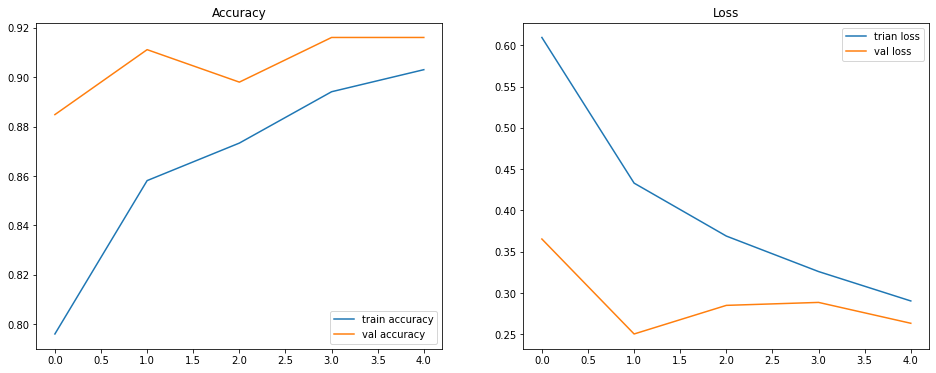

In [85]:
plot_loss_curves(model_2_fine_tune_all_data_history)

So sánh mức độ hiệu quả của mô hình qua 2 giai đoạn, trước khi tinh chỉnh mô hình với 10% dữ liệu train, và giai đoạn tinh chỉnh với đầy đủ dữ liệu train, và tất cả dữ liệu đều được tăng cường tính đa dạng. 

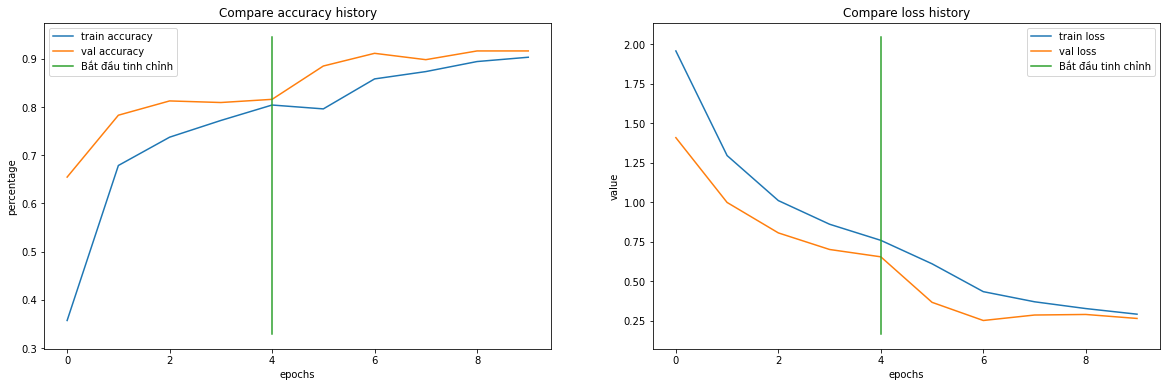

In [86]:
compare_history(model_2_history,model_2_fine_tune_all_data_history)

## 6. So sánh kết quả thử nghiệm mô các mô hình hình bằng TensorBoard


Kết quả thử nghiệm các mô hình đã được lưu lại trong tensornoard. Nếu chúng ta muốn chia sẻ chúng với ai đó, họ sẽ nhận được biểu đồ và các số liệu đánh giá từ các mô hình. 

> 🔑 **Lưu ý**: Nhớ rằng mọi thứ bạn upload lên `TensorBoard.dev` đều được công khai. Nếu có những thông tin nhạy, vui lòng cảm đừng tải lên.



In [88]:
!tensorboard dev upload --logdir transfer_learning_fine_tuning \
--name "Transfer learning experiments" \
--description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
--one_shot

2021-09-10 03:47:53.888319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:47:53.905487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:47:53.906320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

transfer_learning_fine_tuning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms

Khi chúng ta đã upload các kết quả lên `TensorBoard.dev`, chúng ta sẽ nhận được một liên kết có thể chia sẻ mà chúng ta có thể sử dụng để xem và so sánh các thử nghiệm của mình và chia sẻ những kết quả đó với những người khác nếu cần.

Để tìm tất cả các thử nghiệm `TensorBoard.dev` bạn có thể gõ lệnh để hiển thị danh sách các thử nghiệm đã diễn ra : 

In [91]:
!tensorboard dev list

2021-09-10 03:51:27.078943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:51:27.086742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:51:27.087321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/flO1jVwrSwi4HWFVJqZ7pQ/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   flO1jVwrSwi4HWFVJqZ7pQ
	Created              2021-09-10 03:48:14 (3 minutes ago)
	Update

Để xóa những thử nghiệm nào đó, bạn có thể dùng lệnh : 

`tensorboard dev delete --experiment_id [Id của thử nghiệm]`

In [94]:
!tensorboard dev delete --experiment_id y0VMGHgcRZWTl8vmFririg

2021-09-10 03:53:19.223485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:53:19.231735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:53:19.232317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Deleted experiment y0VMGHgcRZWTl8vmFririg.


Kiểm tra lại danh sách xem thử nghiệm với Id `y0VMGHgcRZWTl8vmFririg` đã được xóa chưa

In [95]:
!tensorboard dev list

2021-09-10 03:54:28.523190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:54:28.531792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 03:54:28.532426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/flO1jVwrSwi4HWFVJqZ7pQ/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   flO1jVwrSwi4HWFVJqZ7pQ
	Created              2021-09-10 03:48:14 (6 minutes ago)
	Update